# Oxford-IIIT Pet UNet Segmentation

This demo showcases the UNet architecture. It repeatedly downsamples the input image using a maxpooling layer followed by a convolutional block consisting of 2 convolutional layers the preserve width x height, but double the channels. This is followed by an upsampling process which goes as follows:
1. The current input is upsampled with a 2x2 transpose convolution
2. The image with the same width x height from the downsampling process is concatenated to this along the channel dimension
3. This deeper image undergoes convolution to half the number of channels

An image of the model architecture is depicting below:

![Image of UNet Architecture](unet.png "UNet")

The purpose of this demo is to segment the image into 3 classes: Animal, Edge, Background. So the model learns to classify at the pixel level, with each of the 3 output channels corresponding to one of the classes. The UNet is a powerful architecture because it allows the model to apply numerous filters to help it learn segmentation, all while using the concatention process to preserve the original image structure at every step of the reconstruction.

## Imports

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from model import UNet
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128), antialias=True),
    transforms.ToTensor()
])

data = torchvision.datasets.OxfordIIITPet(
    root=".",
    target_types='segmentation',
    download=True,
    transform=transform,
    target_transform=transform
)
train, validation = torch.utils.data.random_split(data, (3000, 680))

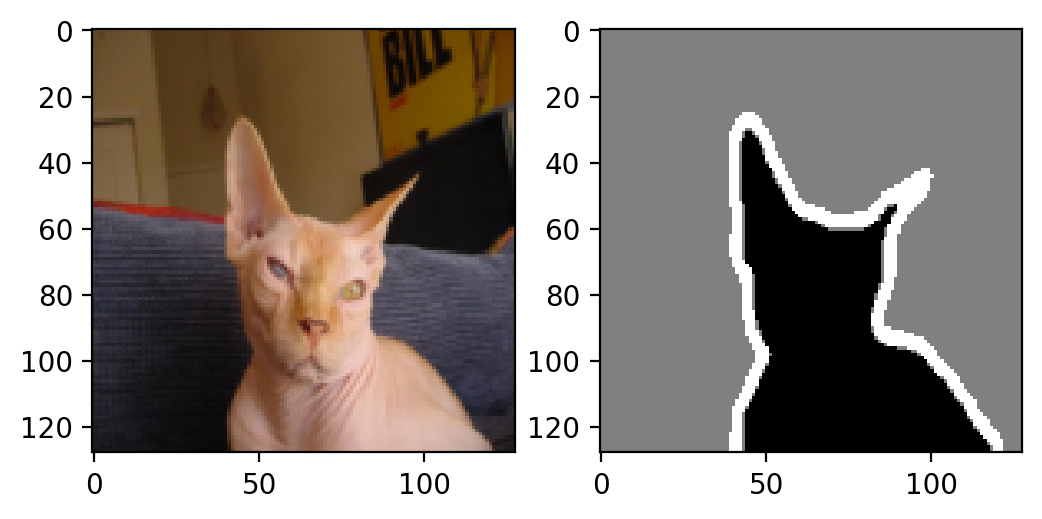

In [3]:
loader = DataLoader(dataset=train, batch_size=1, shuffle=True)
for [image, segmentation] in loader:
    fig, axes = plt.subplots(1, 2)
    fig.set_dpi(200)
    axes[0].imshow(image.squeeze().permute(1, 2, 0), cmap="gray")
    axes[1].imshow(segmentation.squeeze(), cmap="gray")
    break

## Hyperparameters + Initialize Model

In [11]:
device = "mps"
unet = UNet(
    image_channels=3,
    hidden_channels=32,
    n_classes=3
).to(device)

loader = DataLoader(dataset=train, batch_size=16, shuffle=True)
validation_loader = DataLoader(dataset=validation, batch_size=16, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-3)
loss_history = []

In [17]:
optimizer.lr = 3e-4

In [ ]:
epochs = 10
for epoch in range(epochs):
    unet.train()
    training_loss = 0
    for batch, [image, segmentation] in enumerate(loader):
        image, segmentation = image.to(device), ((segmentation.to(device) * 255)//1 - 1).long()
        prediction = unet(image)

        segmentation = segmentation.squeeze(dim=1)
        loss = criterion(prediction, segmentation)
        training_loss += loss.item()


        unet.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 4 == 0:
            print(f"Batch {batch + 1}/{len(loader)} | Loss {loss.item()}")
            loss_history.append(loss.item())

    with torch.no_grad():
        unet.eval()
        validation_loss = 0
        for [image, segmentation] in validation_loader:
            image, segmentation = image.to(device), ((segmentation.to(device) * 255)//1 - 1).long()

            prediction = unet(image)
            segmentation = segmentation.squeeze(dim=1)
            loss = criterion(prediction, segmentation)
            validation_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs} | Average Training Loss: {training_loss/len(loader)} | Validation Loss: {validation_loss/len(validation_loader)}")


## Display Loss History

(0.0, 747.6)

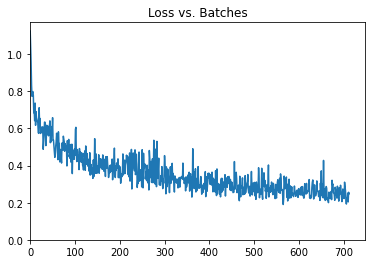

In [19]:
x_axis = range(len(loss_history))
plt.plot(x_axis, loss_history)
plt.title("Loss vs. Batches")
plt.ylim(0)
plt.xlim(0)

## Show Segmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


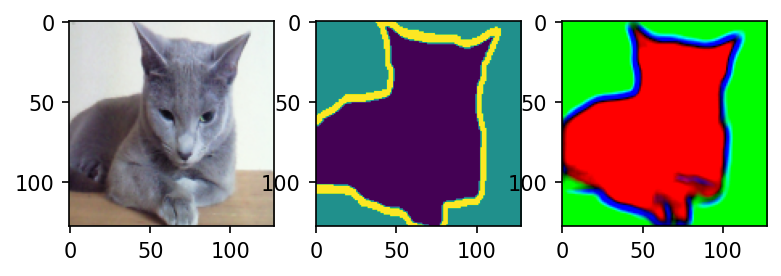

In [31]:
val = DataLoader(dataset=validation, batch_size=1, shuffle=True)
for [image, segmentation] in val:
    image = image.to(device)
    image, segmentation, prediction = image.squeeze().permute(1, 2, 0), segmentation.squeeze().squeeze(), unet(image).squeeze().permute(1, 2, 0)
    fig, axes = plt.subplots(1, 3)
    fig.set_dpi(150)
    axes[0].imshow(image.cpu())
    axes[1].imshow(segmentation)
    axes[2].imshow(prediction.cpu().detach())
    break